# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
!pip install ipywidgets widgetsnbextension pandas-profiling
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 138 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 43.8 MB/s eta 0:00:01
     |████████████████████████████████| 324 kB 48.0 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 45.6 MB/s eta 0:00:01
     |████████████████████████████████| 352 kB 45.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 32.9 MB/s eta 0:00:01
     |████████████████████████████████| 293 kB 36.8 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 43.6 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 9.9 MB 39.2 MB/s eta 0:00:01
     |████████████████████████████████| 680 kB 45.4 MB/s eta 0:00:01
     |████████████████████████████████| 437 kB 37.0 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.5 MB/s  eta 0:00:01
     |██████████████████████

In [3]:
import os
im_size = 18
bs = 128

# means = [0.485, 0.456, 0.406]   ## normalize for RGB
# stds = [0.229, 0.224, 0.225]
means = 0.5                       ## normalize for Grayscale
stds = 0.5

# Define transforms
## YOUR CODE HERE ##
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=im_size*1.5, scale=(0.8, 1.0)),
    transforms.CenterCrop(im_size),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=means, std=stds),
])
test_transforms = transforms.Compose([
    transforms.Resize(size=im_size),
    transforms.ToTensor()
])

if not os.path.exists('./dataset'):
    os.mkdir('./dataset')
# Create training set and define training dataloader
## YOUR CODE HERE ##
train_datasets = torchvision.datasets.MNIST(root='./dataset', train=True,
                                        download=True, transform=data_transforms)
# split train_dataset to train-validation dataset
tot_train = int(len(train_datasets) * 0.8)
tot_val = len(train_datasets) - tot_train
train_datasets, valid_datasets = torch.utils.data.random_split(train_datasets, [tot_train, tot_val])

trainloader = torch.utils.data.DataLoader(train_datasets, batch_size=bs, 
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_datasets, batch_size=bs, 
                                         shuffle=True, num_workers=2)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_datasets = torchvision.datasets.MNIST(root='./dataset', train=False,
                                       download=True, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_datasets, batch_size=bs, 
                                         shuffle=False, num_workers=2)


len(trainloader), len(validloader), len(testloader)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(375, 94, 79)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

For the transform process in training, I use `RandomRezisedCrop` with a size of 1.5 times the pixel size I want to use (`im_size`), the goal is when doing `CenterCrop` to `im_size`, the image features are not lost because of cropping. Then I use `RandomRotation` with an angle of `20 degrees` to add variation to the data by means of rotation. Finally change the data to Tensor and normalize it.

The test data only applies `ToTensor` and `Normalize`, because it is intended to test the original data

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:bs]
    images = batch[0][0:bs]
    for i in range(bs//8):
    
        image = images[i].numpy()
        print('label:', int(labels[i].detach()),', image dim:', image.shape)
#         print('===', image.ravel())
        plt.subplot(1, 2, 1)
        plt.imshow(image.T.squeeze().T)
        
        plt.subplot(1, 2, 2)
        plt.hist(image.ravel(), bins=50, density=True); 
        plt.title('Histogram - pixel distribution')
        plt.show()        

label: 5 , image dim: (1, 18, 18)


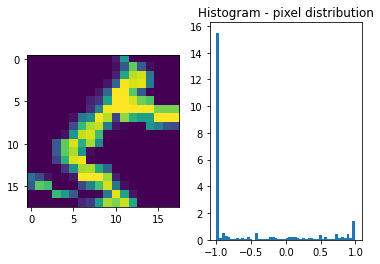

label: 2 , image dim: (1, 18, 18)


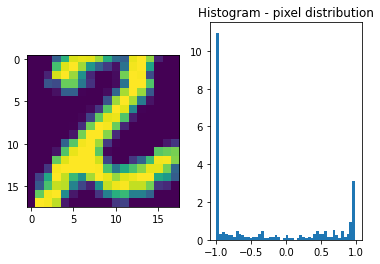

label: 1 , image dim: (1, 18, 18)


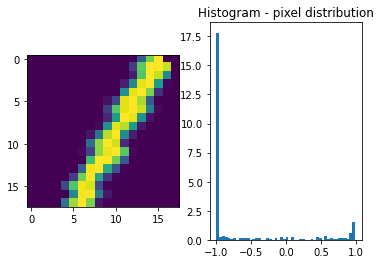

label: 0 , image dim: (1, 18, 18)


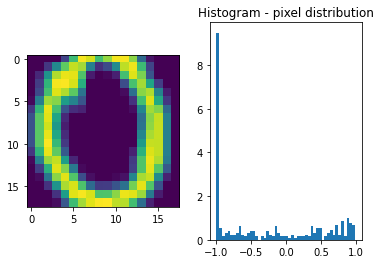

label: 0 , image dim: (1, 18, 18)


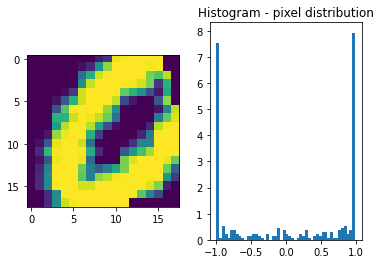

label: 4 , image dim: (1, 18, 18)


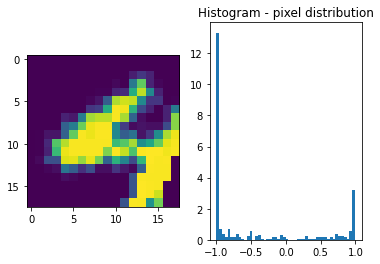

label: 0 , image dim: (1, 18, 18)


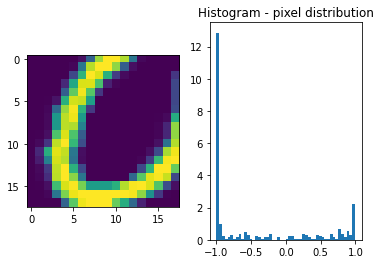

label: 5 , image dim: (1, 18, 18)


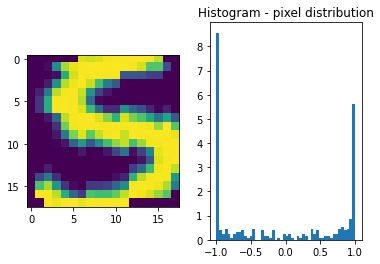

label: 5 , image dim: (1, 18, 18)


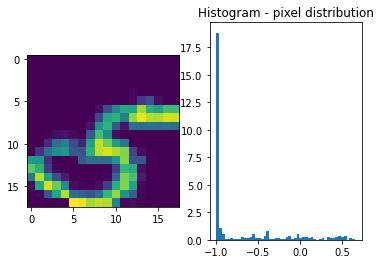

label: 7 , image dim: (1, 18, 18)


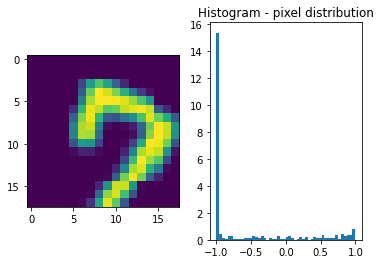

label: 7 , image dim: (1, 18, 18)


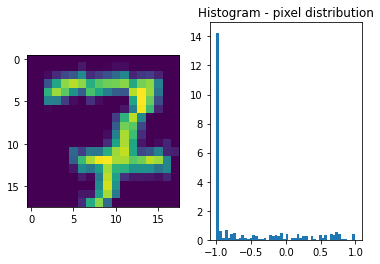

label: 6 , image dim: (1, 18, 18)


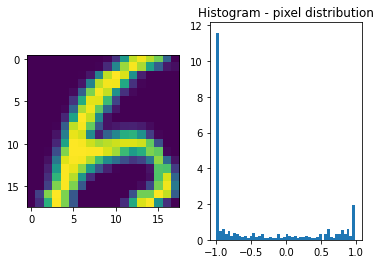

label: 8 , image dim: (1, 18, 18)


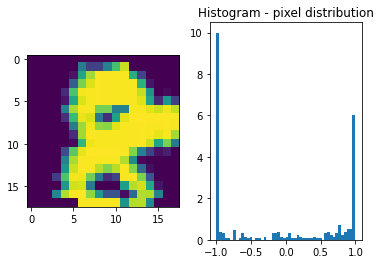

label: 9 , image dim: (1, 18, 18)


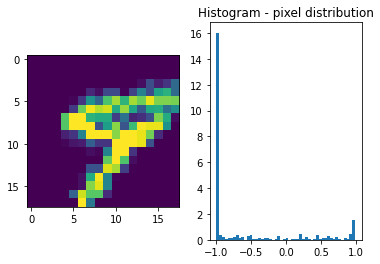

label: 8 , image dim: (1, 18, 18)


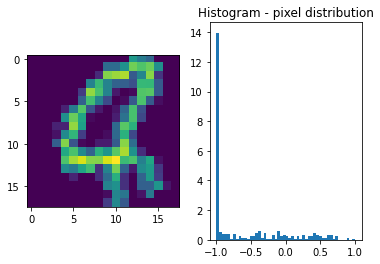

label: 7 , image dim: (1, 18, 18)


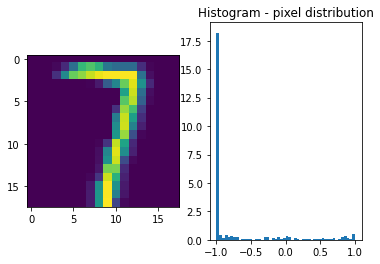

In [5]:
# Explore data
## YOUR CODE HERE ##

show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [7]:
## YOUR CODE HERE ##
# from torchsummary import summary
dim = im_size
channels = 1    # because the images are grayscale
out_class = 10

class Model(torch.nn.Module):
    def __init__(self, in_features=64, n_classes=10, ch=1, 
                 hidden_layer=[32, 32, 32], drop_out=[0, 0, 0]):
        super(Model, self).__init__()        
        self.act_fc = nn.ReLU()
        self.act_out = nn.LogSoftmax(dim=1)

        self.flatern = nn.Flatten()
        self.fc_in = nn.Linear((in_features**2)*ch, hidden_layer[0])
        self.dropout_in = nn.Dropout(drop_out[0])
        
#         self.fc_h1 = nn.Linear(hidden_layer[0], hidden_layer[1])
#         self.dropout_h1 = nn.Dropout(drop_out[1])
        
#         self.fc_h2 = nn.Linear(hidden_layer[1], hidden_layer[2])
#         self.dropout_h2 = nn.Dropout(drop_out[2])
        
        self.fc_out = nn.Linear(hidden_layer[0], n_classes)

    def forward(self, x):
        x = self.flatern(x)
        
        x = self.act_fc(self.fc_in(x))
        x = self.dropout_in(x)
        
#         x = self.act_fc(self.fc_h1(x))
#         x = self.dropout_h1(x)
        
#         x = self.act_fc(self.fc_h2(x))
#         x = self.dropout_h2(x)
        
        out = self.fc_out(x)
#         out = self.act_out(self.fc_out(x))
        return out


model = Model(in_features=dim, n_classes=out_class, ch=channels, hidden_layer=[32, 16, 256], drop_out=[0, 0, 0.6])
# summary(model, (channels, dim,dim), device='cpu')
model.state_dict

<bound method Module.state_dict of Model(
  (act_fc): ReLU()
  (act_out): LogSoftmax(dim=1)
  (flatern): Flatten(start_dim=1, end_dim=-1)
  (fc_in): Linear(in_features=324, out_features=32, bias=True)
  (dropout_in): Dropout(p=0, inplace=False)
  (fc_out): Linear(in_features=32, out_features=10, bias=True)
)>

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
## YOUR CODE HERE ##
import torch.optim as optim
import torch.nn as nn
learning_rate = 0.001
eps = 20

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc_out.parameters(), lr=learning_rate)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
model_config = {
    'train_dataloader' : trainloader, 
    'valid_dataloader' : validloader, 
    'test_dataloader' : testloader,
    
    'model' : model,
    'criterion' : criterion,
    'optimizer' : optimizer,
    
    'lr' : learning_rate,
    'img_size' : im_size,
    'batch_size' : bs,
    'epochs' : eps,
    
    'regularization' : None,
    'lr_scheduler' : None,
    'early_stopping' : None,
    
    'device' : 'cuda:0' if torch.cuda.is_available() else 'cpu'   
}

In [10]:
## YOUR CODE HERE ##
from tqdm import tqdm

def model_iter(model=None, dataloader=None, mode='train', config=None):
    correct, cost = 0, 0
    counter = 0
    total = 0
    
#     model = config['model'] if model is None else model
    criter = config['criterion']
    optim = config['optimizer']
    reg_loss = config['regularization']
    device = config['device']
    
    if mode=='train':
        model.train()
    elif mode=='valid':
        model.eval()
        
    for X, y in tqdm(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        counter += 1
        total += y.size(0)
        
        output = model(X)
        loss = criterion(output , y)
        
        if reg_loss is not None:
            if isinstance(reg_loss, str):
                loss = loss + regularization(model, reg_loss)
            else:
                loss = loss
        else:
            loss = loss
            
        if mode=='train':
            loss.backward()
            optim.step()
            optim.zero_grad()
        _, preds = torch.max(output.data, 1)
        correct += (preds == y).sum().item()
#         correct += (output.argmax(1) == y).sum().item()
#         correct = correct/X.shape[0]    
        cost += loss.item()
#     correct = correct/len(dataloader)
#     cost = cost/len(dataloader)
    cost =  cost/counter
    correct = correct/total
    return round(correct, 7), round(cost, 9), model



def fit_model(config=None, eval=False):
    history = {
        'model' : [],
        'train_acc' : [],
        'test_acc' : [],
        'train_loss' : [],
        'test_loss' : [],
        'epochs' : []
    }
    trainloader = config['train_dataloader']
    testloader = config['valid_dataloader']
    
    model = config['model'].to(config['device'])
    criter = config['criterion']
    optim = config['optimizer']
    
    epochs = config['epochs']
    bs = config['batch_size']
    
    if config['lr_scheduler'] is not None:
        print('INFO: Initializing learning rate scheduler')
        lr_scheduler = config['lr_scheduler']
#         lr_scheduler = LRScheduler(optim)
    if config['early_stopping'] is not None:
        print('INFO: Initializing early stopping')
        early_stopping = config['early_stopping']
#         early_stopping = EarlyStopping()
    
    try:
        for eps in range(epochs):
            train_acc, train_cost, model_result = model_iter(model, dataloader=trainloader, mode='train', config=config)
            history['train_acc'].append(train_acc)
            history['train_loss'].append(train_cost)
            print('===[EPOCH: {:>4}]==========================='.format(eps + 1))
            print('train_loss = {:}, train_acc = {:}'.format(train_cost, train_acc))

            if eval == True:
                with torch.no_grad():
                    val_acc, val_cost, _ = model_iter(model=model_result, dataloader=testloader, mode='valid', config=config)
                    history['test_acc'].append(val_acc)
                    history['test_loss'].append(val_cost)
                    print('val_loss = {:}, val_acc = {:}'.format(val_cost, val_acc))
            print('============================================')
            history['epochs'].append(eps+1)
            history['model'].append(model_result)

            if config['lr_scheduler'] is not None:
                lr_scheduler(val_cost)
            if config['early_stopping'] is not None:
                early_stopping(val_cost)
                if early_stopping.early_stop:
                    break
    except KeyboardInterrupt:
        print()
        print('Interrupted')
        
    return history
    

train_result = fit_model(model_config, eval=True)

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    1]===========================
train_loss = 2.112001305, train_acc = 0.31575


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.95266249, val_acc = 0.4071667


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    2]===========================
train_loss = 1.84550989, train_acc = 0.4481458


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.763526891, val_acc = 0.464


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    3]===========================
train_loss = 1.702714098, train_acc = 0.4813333


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.638741637, val_acc = 0.494


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    4]===========================
train_loss = 1.607761068, train_acc = 0.5025625


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.577341922, val_acc = 0.5049167


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    5]===========================
train_loss = 1.549538218, train_acc = 0.5099583


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.528331187, val_acc = 0.5170833


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    6]===========================
train_loss = 1.502799596, train_acc = 0.521875


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.497068536, val_acc = 0.5174167


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    7]===========================
train_loss = 1.474791787, train_acc = 0.5247708


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.453338353, val_acc = 0.5296667


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    8]===========================
train_loss = 1.449251992, train_acc = 0.5305


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.436481863, val_acc = 0.5385833


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    9]===========================
train_loss = 1.434054973, train_acc = 0.5332292


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.42861615, val_acc = 0.5364167


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   10]===========================
train_loss = 1.421068493, train_acc = 0.5360208


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.409729889, val_acc = 0.5359167


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   11]===========================
train_loss = 1.404585181, train_acc = 0.5419167


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.421404016, val_acc = 0.5324167


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   12]===========================
train_loss = 1.397410614, train_acc = 0.5397292


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.402464069, val_acc = 0.5365


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   13]===========================
train_loss = 1.384512544, train_acc = 0.5457292


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.375383109, val_acc = 0.549


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   14]===========================
train_loss = 1.388120192, train_acc = 0.5442083


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.395303138, val_acc = 0.5379167


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   15]===========================
train_loss = 1.379002724, train_acc = 0.5481667


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.3868278, val_acc = 0.5401667


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   16]===========================
train_loss = 1.373590787, train_acc = 0.5489375


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.389938403, val_acc = 0.5394167


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   17]===========================
train_loss = 1.368641699, train_acc = 0.5492917


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.366904227, val_acc = 0.5491667


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   18]===========================
train_loss = 1.372515113, train_acc = 0.5464375


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.364666664, val_acc = 0.54875


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   19]===========================
train_loss = 1.367069931, train_acc = 0.5505625


  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 1.359133572, val_acc = 0.55425


  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   20]===========================
train_loss = 1.364467539, train_acc = 0.5508958


100%|██████████| 94/94 [00:03<00:00, 26.36it/s]

val_loss = 1.356924278, val_acc = 0.55325


Plot the training loss (and validation loss/accuracy, if recorded).

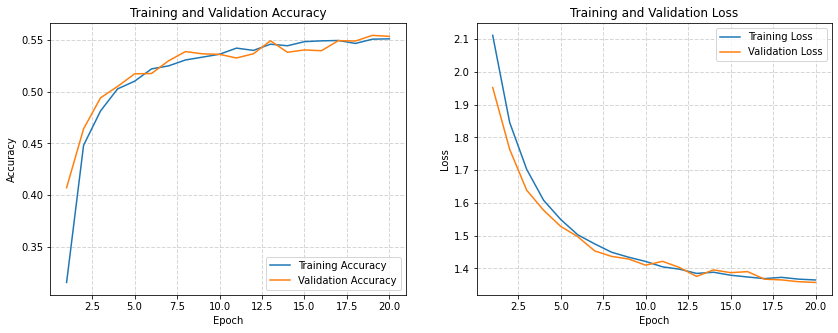

In [11]:
## YOUR CODE HERE ##
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline

def training_plot(hist, accuracy=False):
    acc = hist['train_acc']
    val_acc = hist['test_acc']
    loss = hist['train_loss']
    val_loss = hist['test_loss']
    # eps = list(range(hist['epochs'][0]))
    eps = hist['epochs']
    
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(eps, acc, label='Training Accuracy')
    plt.plot(eps, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    if accuracy is True:
        plt.subplot(1, 2, 2)
        plt.plot(eps, loss, label='Training Loss')
        plt.plot(eps, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    
    plt.show()


training_plot(train_result, accuracy=True)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
## YOUR CODE HERE ##
# for imgs, labels in testloader:
# features, targets = next(iter(validloader))
# features, targets = features.to(device), targets.to(device)
# with torch.no_grad():
#     model.eval()
#     output = model(features)
#     preds = output.argmax(1)
# print('accuracy: ',float((targets == preds).to(torch.float32).mean()))

model = train_result['model'][0]
with torch.no_grad():
    model.eval()
    acc, _, _ = model_iter(model=model, dataloader=testloader, mode='valid', config=model_config)
    print('Test Accuracy = {:.2f}%'.format(acc*100))

100%|██████████| 79/79 [00:01<00:00, 49.02it/s]

Test Accuracy = 17.06%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [67]:
## YOUR CODE HERE ##
## adding regularization method
def regularization(model=None, option=None, lambda_l1=0.2, lambda_l2=0.2):

    parameters = []
    for param in model.parameters():
        # param.requires_grad = True
        parameters.append(param.view(-1))
        w = torch.cat(parameters)
    l1 = lambda_l1 * torch.abs(w).sum()
    l2 = lambda_l2 * torch.square(w).sum()

    if option == 'l1':                ## Lasso / L1
        return l1
    elif option == 'l2':              ## Ridge / L2
        return l2
    elif option == 'elasticnet':      ## Elastic net / L1 L2
        return l1 + l2
    else:
        return 0

In [14]:
## adding earlystop object
class EarlyStopping():      # reference: https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
    def __init__(self, patience=5, min_delta=0):
        """
        early_stop = ((best_loss - val_loss) < self.min_delta) && (train_iter >= patience)
        """
        self.patience = patience    # how many epochs to wait before stopping when loss is not improving
        self.min_delta = min_delta  # minimum difference between new loss and old loss for new loss to be considered as an improvement
        self.train_iter_count = 0
        self.best_loss = None
        self.early_stop = False     # training epoch will be stoping if early_stop is True
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.train_iter_count = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.train_iter_count += 1
            print(f"INFO: Early stopping counter {self.train_iter_count} of {self.patience}")
            if self.train_iter_count >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [15]:
## adding learning rate scheduler

class LRScheduler():
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        """
        new_lr = old_lr * factor
        """
        self.optimizer = optimizer
        self.patience = patience    # how many epochs to wait before updating the lr
        self.min_lr = min_lr        # least lr value to reduce to while updating
        self.factor = factor        # factor by which the lr should be updated
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [80]:
## model config
model = Model(in_features=dim, n_classes=out_class, ch=channels, hidden_layer=[32, 128, 256], drop_out=[0, 0.6, 0.6])

# optimizer
learning_rate = 0.007
adam_optimizer = optim.Adam(model.parameters(), lr=learning_rate)
sgd_optimizer = optim.SGD(model.parameters(), lr=learning_rate)
rmsprop_optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)



model_config = {
    'train_dataloader' : trainloader, 
    'valid_dataloader' : validloader, 
    'test_dataloader' : testloader,
    
    'model' : model,
    'criterion' : nn.CrossEntropyLoss(),
    'optimizer' : rmsprop_optimizer,
    
    'lr' : learning_rate,
    'img_size' : im_size,
    'batch_size' : bs,
    'epochs' : 100,
    
    'regularization' : None,
    'lr_scheduler' : LRScheduler(rmsprop_optimizer),
    'early_stopping' : EarlyStopping(patience=5),
    
    'device' : 'cuda:0' if torch.cuda.is_available() else 'cpu'   
}

In [81]:
# # hyperparameter tuning for hidden layer nodes

# for nodes in [32, 64, 128, 256, 512]:
#     for drop in [0, 0.1, 0.2, 0.25, 0.3]
#         model = Model(in_features=dim, n_classes=out_class, ch=channels, hidden_layer=[32, nodes, 256], drop_out=[0, drop, 0.6])
#         hist_improve = fit_model(model_config, eval=True)

In [82]:
## YOUR CODE HERE ##
hist_improve = fit_model(model_config, eval=True)


  0%|          | 0/375 [00:00<?, ?it/s]

INFO: Initializing learning rate scheduler
INFO: Initializing early stopping



100%|██████████| 375/375 [00:13<00:00, 28.10it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    1]===========================
train_loss = 0.699266516, train_acc = 0.7803542



100%|██████████| 94/94 [00:03<00:00, 24.50it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.486735683, val_acc = 0.8493333



100%|██████████| 375/375 [00:13<00:00, 27.85it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    2]===========================
train_loss = 0.477346999, train_acc = 0.8536458



100%|██████████| 94/94 [00:03<00:00, 24.29it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.451425759, val_acc = 0.8621667



100%|██████████| 375/375 [00:13<00:00, 27.70it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    3]===========================
train_loss = 0.422265935, train_acc = 0.8695



100%|██████████| 94/94 [00:03<00:00, 27.31it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.424453869, val_acc = 0.87075



100%|██████████| 375/375 [00:13<00:00, 27.20it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    4]===========================
train_loss = 0.407802599, train_acc = 0.8780417



100%|██████████| 94/94 [00:03<00:00, 26.20it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.414753147, val_acc = 0.8698333



100%|██████████| 375/375 [00:14<00:00, 26.60it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    5]===========================
train_loss = 0.393007561, train_acc = 0.8802292



100%|██████████| 94/94 [00:03<00:00, 24.00it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.398533754, val_acc = 0.8798333



100%|██████████| 375/375 [00:14<00:00, 26.22it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    6]===========================
train_loss = 0.375422181, train_acc = 0.8873958



100%|██████████| 94/94 [00:03<00:00, 25.96it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.373921823, val_acc = 0.8889167



100%|██████████| 375/375 [00:15<00:00, 24.82it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    7]===========================
train_loss = 0.374740613, train_acc = 0.8882708



100%|██████████| 94/94 [00:03<00:00, 26.24it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.365490128, val_acc = 0.8895833



100%|██████████| 375/375 [00:14<00:00, 26.41it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    8]===========================
train_loss = 0.361361283, train_acc = 0.8923125



100%|██████████| 94/94 [00:03<00:00, 25.92it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.365753468, val_acc = 0.8926667
INFO: Early stopping counter 1 of 4



100%|██████████| 375/375 [00:13<00:00, 26.92it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:    9]===========================
train_loss = 0.359062238, train_acc = 0.8926042



100%|██████████| 94/94 [00:03<00:00, 24.69it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.356869102, val_acc = 0.8913333



100%|██████████| 375/375 [00:13<00:00, 27.12it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   10]===========================
train_loss = 0.354557158, train_acc = 0.8935417



100%|██████████| 94/94 [00:03<00:00, 25.32it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.354502865, val_acc = 0.8946667



100%|██████████| 375/375 [00:13<00:00, 27.35it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   11]===========================
train_loss = 0.352843554, train_acc = 0.8951875



100%|██████████| 94/94 [00:03<00:00, 25.51it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.357412576, val_acc = 0.8935
INFO: Early stopping counter 1 of 4



100%|██████████| 375/375 [00:14<00:00, 26.69it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   12]===========================
train_loss = 0.343417701, train_acc = 0.8959792



100%|██████████| 94/94 [00:03<00:00, 26.06it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.341543346, val_acc = 0.8970833



100%|██████████| 375/375 [00:14<00:00, 26.22it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   13]===========================
train_loss = 0.343495427, train_acc = 0.8968542



100%|██████████| 94/94 [00:03<00:00, 26.95it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.342685342, val_acc = 0.8974167
INFO: Early stopping counter 1 of 4



100%|██████████| 375/375 [00:14<00:00, 26.34it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   14]===========================
train_loss = 0.337061783, train_acc = 0.8999583



100%|██████████| 94/94 [00:03<00:00, 23.53it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.333292233, val_acc = 0.9026667



100%|██████████| 375/375 [00:14<00:00, 26.31it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   15]===========================
train_loss = 0.335897698, train_acc = 0.8995



100%|██████████| 94/94 [00:04<00:00, 23.40it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.379750382, val_acc = 0.88275
INFO: Early stopping counter 1 of 4



100%|██████████| 375/375 [00:14<00:00, 25.15it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   16]===========================
train_loss = 0.336972797, train_acc = 0.8996875



100%|██████████| 94/94 [00:03<00:00, 23.81it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.353103386, val_acc = 0.8988333
INFO: Early stopping counter 2 of 4



100%|██████████| 375/375 [00:14<00:00, 26.40it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   17]===========================
train_loss = 0.338136504, train_acc = 0.9008542



100%|██████████| 94/94 [00:03<00:00, 23.81it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

val_loss = 0.336646643, val_acc = 0.9014167
INFO: Early stopping counter 3 of 4



100%|██████████| 375/375 [00:14<00:00, 25.64it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

===[EPOCH:   18]===========================
train_loss = 0.328473343, train_acc = 0.9014167



100%|██████████| 94/94 [00:03<00:00, 23.88it/s]

val_loss = 0.348087756, val_acc = 0.9015833
INFO: Early stopping counter 4 of 4
INFO: Early stopping


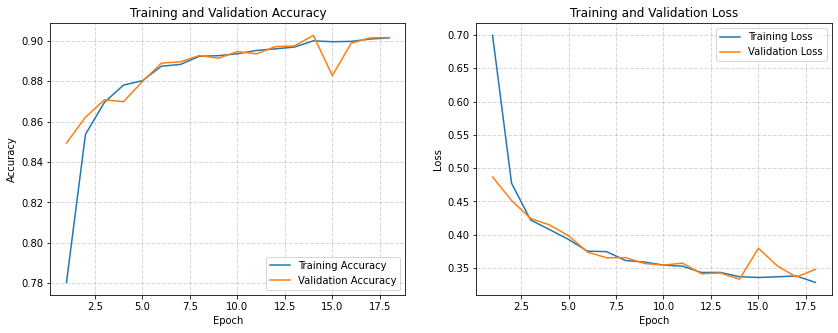


100%|██████████| 94/94 [00:03<00:00, 25.44it/s]

Test Accuracy = 89.97%


In [86]:
training_plot(hist_improve, accuracy=True)

model_final = hist_improve['model'][0]

with torch.no_grad():
    model_final.eval()
    acc, _, _ = model_iter(model=model_final, dataloader=validloader, mode='valid', config=model_config)
    print('Test Accuracy = {:.2f}%'.format(acc*100))

## Saving your model
Using `torch.save`, save your model for future loading.

In [85]:
## YOUR CODE HERE ##
model_final = hist_improve['model'][0]
torch.save(model_final.state_dict(), 'model.pt')